In [69]:
import nltk
nltk.download('stopwords')

import numpy as np
import pandas as pd
import os
import re
import matplotlib.pyplot as plt
from nltk.corpus import stopwords
from bs4 import BeautifulSoup 
from tensorflow.keras.preprocessing.text import Tokenizer 
from tensorflow.keras.preprocessing.sequence import pad_sequences
import urllib.request
import warnings
warnings.filterwarnings("ignore", category=UserWarning, module='bs4')
import urllib.request

#data upload
urllib.request.urlretrieve("https://raw.githubusercontent.com/sunnysai12345/News_Summary/master/news_summary_more.csv", filename="news_summary_more.csv")
data = pd.read_csv('news_summary_more.csv', encoding='iso-8859-1')

[nltk_data] Downloading package stopwords to /aiffel/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [70]:
data.sample(10) #셈플 확인 headlines (요약) / text (내용)

,headlines,text
68961,Who delivered India's response to Pakistan at UN?,"Eenam Gambhir, who delivered a response to Pak..."
3892,Need to take care of artistes: Shatrughan on K...,Speaking about veteran actor Kader Khan who pa...
72830,100 carrier pigeons used for smuggling drugs s...,Anti-narcotics forces in Iran have seized up t...
27540,ICC to give strict ball tampering bans post Au...,ICC has decided to hand stricter bans for ball...
9704,Mehul Choksi medically unfit to travel to Indi...,During the hearing of Enforcement Directorate'...
74645,200 cows die in Chhattisgarh BJP leader's cow ...,"At least 200 cows have died of ""starvation or ..."
77203,Bombay HC accuses govt of being biased to kaal...,The Bombay High Court has accused the governme...
74472,One cop killed 4 terrorists during Spain terro...,A Spanish police officer reportedly single-han...
37159,Soz's Kashmir remark cheap tactic to sell his ...,Congress spokesperson Randeep Surjewala said t...
61562,"If Karisma wants to marry, she has my blessing...",Talking about reports of his daughter Karisma ...


In [71]:
#추상적 요약
#1. 데이터 전처리
#1-1. 중복 검사
print('Text 열에서 중복을 배제한 유일한 샘플의 수 :', data['text'].nunique())
print('Healines 열에서 중복을 배제한 유일한 샘플의 수 :', data['headlines'].nunique())

Text 열에서 중복을 배제한 유일한 샘플의 수 : 98360
Healines 열에서 중복을 배제한 유일한 샘플의 수 : 98280


In [72]:
#1-2. 중복 제거
data.drop_duplicates(subset = ['text'], inplace=True) #drop_duplicates() : 중복된 값을 가지는 샘플을 제거
print('전체 샘플수 :', (len(data)))

전체 샘플수 : 98360


In [73]:
#1-3. Null 값 확인
print(data.isnull().sum())

headlines    0
text         0
dtype: int64


In [74]:
#1-4. 텍스트 정규화, 불용어 제거

contractions = {"ain't": "is not", "aren't": "are not","can't": "cannot", "'cause": "because", "could've": "could have", "couldn't": "could not",
                           "didn't": "did not",  "doesn't": "does not", "don't": "do not", "hadn't": "had not", "hasn't": "has not", "haven't": "have not",
                           "he'd": "he would","he'll": "he will", "he's": "he is", "how'd": "how did", "how'd'y": "how do you", "how'll": "how will", "how's": "how is",
                           "I'd": "I would", "I'd've": "I would have", "I'll": "I will", "I'll've": "I will have","I'm": "I am", "I've": "I have", "i'd": "i would",
                           "i'd've": "i would have", "i'll": "i will",  "i'll've": "i will have","i'm": "i am", "i've": "i have", "isn't": "is not", "it'd": "it would",
                           "it'd've": "it would have", "it'll": "it will", "it'll've": "it will have","it's": "it is", "let's": "let us", "ma'am": "madam",
                           "mayn't": "may not", "might've": "might have","mightn't": "might not","mightn't've": "might not have", "must've": "must have",
                           "mustn't": "must not", "mustn't've": "must not have", "needn't": "need not", "needn't've": "need not have","o'clock": "of the clock",
                           "oughtn't": "ought not", "oughtn't've": "ought not have", "shan't": "shall not", "sha'n't": "shall not", "shan't've": "shall not have",
                           "she'd": "she would", "she'd've": "she would have", "she'll": "she will", "she'll've": "she will have", "she's": "she is",
                           "should've": "should have", "shouldn't": "should not", "shouldn't've": "should not have", "so've": "so have","so's": "so as",
                           "this's": "this is","that'd": "that would", "that'd've": "that would have", "that's": "that is", "there'd": "there would",
                           "there'd've": "there would have", "there's": "there is", "here's": "here is","they'd": "they would", "they'd've": "they would have",
                           "they'll": "they will", "they'll've": "they will have", "they're": "they are", "they've": "they have", "to've": "to have",
                           "wasn't": "was not", "we'd": "we would", "we'd've": "we would have", "we'll": "we will", "we'll've": "we will have", "we're": "we are",
                           "we've": "we have", "weren't": "were not", "what'll": "what will", "what'll've": "what will have", "what're": "what are",
                           "what's": "what is", "what've": "what have", "when's": "when is", "when've": "when have", "where'd": "where did", "where's": "where is",
                           "where've": "where have", "who'll": "who will", "who'll've": "who will have", "who's": "who is", "who've": "who have",
                           "why's": "why is", "why've": "why have", "will've": "will have", "won't": "will not", "won't've": "will not have",
                           "would've": "would have", "wouldn't": "would not", "wouldn't've": "would not have", "y'all": "you all",
                           "y'all'd": "you all would","y'all'd've": "you all would have","y'all're": "you all are","y'all've": "you all have",
                           "you'd": "you would", "you'd've": "you would have", "you'll": "you will", "you'll've": "you will have",
                           "you're": "you are", "you've": "you have"}

def preprocess_sentence(sentence, remove_stopwords=True):# 데이터 전처리 함수
    sentence = sentence.lower() # 텍스트 소문자화
    sentence = BeautifulSoup(sentence, "lxml").text # <br />, <a href = ...> 등의 html 태그 제거
    sentence = re.sub(r'\([^)]*\)', '', sentence) # 괄호로 닫힌 문자열 (...) 제거 Ex) my husband (and myself!) for => my husband for
    sentence = re.sub('"','', sentence) # 쌍따옴표 " 제거
    sentence = ' '.join([contractions[t] if t in contractions else t for t in sentence.split(" ")]) # 약어 정규화
    sentence = re.sub(r"'s\b","", sentence) # 소유격 제거. Ex) roland's -> roland
    sentence = re.sub("[^a-zA-Z]", " ", sentence) # 영어 외 문자(숫자, 특수문자 등) 공백으로 변환
    sentence = re.sub('[m]{2,}', 'mm', sentence) # m이 3개 이상이면 2개로 변경. Ex) ummmmmmm yeah -> umm yeah
    
    # 불용어 제거 (Text)
    if remove_stopwords:
        tokens = ' '.join(word for word in sentence.split() if not word in stopwords.words('english') if len(word) > 1)
    # 불용어 미제거 (Summary)
    else:
        tokens = ' '.join(word for word in sentence.split() if len(word) > 1)
    return tokens

In [75]:
#1-5. 전처리 시작
clean_text = []

for s in data['text']: # 전체 text 데이터에 대한 전처리 (Warning) 매우 오래거리니까 한번만 하자.
    clean_text.append(preprocess_sentence(s))
    
clean_summary = []

for s in data['headlines']: # 전체 headlines 데이터에 대한 전처리 (Warning) 매우 오래거리니까 한번만 하자.
    clean_summary.append(preprocess_sentence(s, False))

In [76]:
#1-6. 전처리 후 Empty값을 Null값으로 대체
data['text'] = clean_text
data['headlines'] = clean_summary

data.replace('', np.nan, inplace=True)

data.isnull().sum()

headlines    0
text         0
dtype: int64

In [77]:
print("Total Sample", (len(data)))

Total Sample 98360


In [78]:
data.dropna(axis=0, inplace=True)
print('전체 샘플수 :', (len(data)))

data.head()

전체 샘플수 : 98360


,headlines,text
0,upgrad learner switches to career in ml al wit...,saurav kant alumnus upgrad iiit pg program mac...
1,delhi techie wins free food from swiggy for on...,kunal shah credit card bill payment platform c...
2,new zealand end rohit sharma led india match w...,new zealand defeated india wickets fourth odi ...
3,aegon life iterm insurance plan helps customer...,aegon life iterm insurance plan customers enjo...
4,have known hirani for yrs what if metoo claims...,speaking sexual harassment allegations rajkuma...


텍스트의 최소 길이 : 1
텍스트의 최대 길이 : 60
텍스트의 평균 길이 : 35.09968483123221
요약의 최소 길이 : 1
요약의 최대 길이 : 16
요약의 평균 길이 : 9.299532330215534


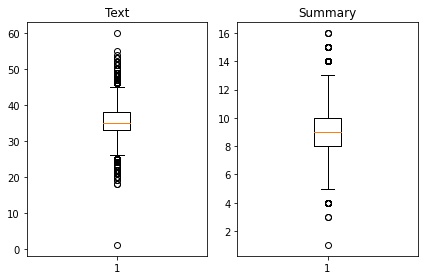

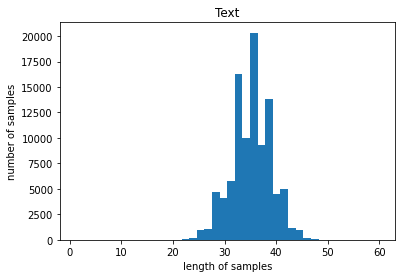

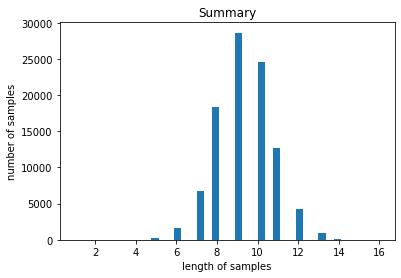

In [79]:
#1-7 정제된 데이터 시각화

text_len = [len(s.split()) for s in data['text']]
summary_len = [len(s.split()) for s in data['headlines']]

print('텍스트의 최소 길이 : {}'.format(np.min(text_len)))
print('텍스트의 최대 길이 : {}'.format(np.max(text_len)))
print('텍스트의 평균 길이 : {}'.format(np.mean(text_len)))
print('요약의 최소 길이 : {}'.format(np.min(summary_len)))
print('요약의 최대 길이 : {}'.format(np.max(summary_len)))
print('요약의 평균 길이 : {}'.format(np.mean(summary_len)))

plt.subplot(1,2,1)
plt.boxplot(text_len)
plt.title('Text')
plt.subplot(1,2,2)
plt.boxplot(summary_len)
plt.title('Summary')
plt.tight_layout()
plt.show()

plt.title('Text')
plt.hist(text_len, bins = 40)
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.show()

plt.title('Summary')
plt.hist(summary_len, bins = 40)
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.show()

In [80]:
#1-8. 적절한 최대 길이 설정
text_max_len = 40
headlines_max_len = 11

def below_threshold_len(max_len, nested_list):#최대 길이를 입력하면 데이터의 몇%가 해당하는지 알려주는 함수
  cnt = 0
  for s in nested_list:
    if(len(s.split()) <= max_len):
        cnt = cnt + 1
  print('전체 샘플 중 길이가 %s 이하인 샘플의 비율: %s'%(max_len, (cnt / len(nested_list))))

below_threshold_len(text_max_len, data['text'])
below_threshold_len(headlines_max_len,  data['headlines'])

전체 샘플 중 길이가 40 이하인 샘플의 비율: 0.9238714924766165
전체 샘플 중 길이가 11 이하인 샘플의 비율: 0.9449877999186661


In [13]:
data = data[data['text'].apply(lambda x: len(x.split()) <= text_max_len)]
data = data[data['headlines'].apply(lambda x: len(x.split()) <= headlines_max_len)]

print('전체 샘플수 :', (len(data)))

전체 샘플수 : 85843


In [81]:
#1-7 요약 데이터에 시작 토큰과 종료 토큰 추가
data['decoder_input'] = data['headlines'].apply(lambda x : 'sostoken '+ x)
data['decoder_target'] = data['headlines'].apply(lambda x : x + ' eostoken')

data.head()

,headlines,text,decoder_input,decoder_target
0,upgrad learner switches to career in ml al wit...,saurav kant alumnus upgrad iiit pg program mac...,sostoken upgrad learner switches to career in ...,upgrad learner switches to career in ml al wit...
1,delhi techie wins free food from swiggy for on...,kunal shah credit card bill payment platform c...,sostoken delhi techie wins free food from swig...,delhi techie wins free food from swiggy for on...
2,new zealand end rohit sharma led india match w...,new zealand defeated india wickets fourth odi ...,sostoken new zealand end rohit sharma led indi...,new zealand end rohit sharma led india match w...
3,aegon life iterm insurance plan helps customer...,aegon life iterm insurance plan customers enjo...,sostoken aegon life iterm insurance plan helps...,aegon life iterm insurance plan helps customer...
4,have known hirani for yrs what if metoo claims...,speaking sexual harassment allegations rajkuma...,sostoken have known hirani for yrs what if met...,have known hirani for yrs what if metoo claims...


In [82]:
#1-8 인코더와 디코더 label을 Numpy타입으로 저장
encoder_input = np.array(data['text']) # 인코더의 입력
decoder_input = np.array(data['decoder_input']) # 디코더의 입력
decoder_target = np.array(data['decoder_target']) # 디코더의 레이블

print(encoder_input.shape)

(98360,)


In [88]:
#1-9. 훈련 데이터와 테스트 데이터 분리
indices = np.arange(encoder_input.shape[0]) #정수 시퀀스 생성
np.random.shuffle(indices)

#정수 시퀀스를 이용해 데이터 셔플
encoder_input = encoder_input[indices]
decoder_input = decoder_input[indices]
decoder_target = decoder_target[indices]

#셔플된 데이터를 8:2로 분리
n_of_val = int(len(encoder_input)*0.2)

encoder_input_train = encoder_input[:-n_of_val]
decoder_input_train = decoder_input[:-n_of_val]
decoder_target_train = decoder_target[:-n_of_val]

encoder_input_test = encoder_input[-n_of_val:]
decoder_input_test = decoder_input[-n_of_val:]
decoder_target_test = decoder_target[-n_of_val:]

print('훈련 데이터의 개수 :', len(encoder_input_train))
print('훈련 레이블의 개수 :', len(decoder_input_train))
print('테스트 데이터의 개수 :', len(encoder_input_test))
print('테스트 레이블의 개수 :', len(decoder_input_test))

훈련 데이터의 개수 : 78688
훈련 레이블의 개수 : 78688
테스트 데이터의 개수 : 19672
테스트 레이블의 개수 : 19672


In [89]:
#1-10. Tokenizer를 사용하여 단어 집합 만들기
src_tokenizer = Tokenizer() # 토크나이저 정의
src_tokenizer.fit_on_texts(encoder_input_train) # 입력된 데이터로부터 단어 집합 생성

threshold = 11
total_cnt = len(src_tokenizer.word_index) # 단어의 수
rare_cnt = 0 # 등장 빈도수가 threshold보다 작은 단어의 개수를 카운트
total_freq = 0 # 훈련 데이터의 전체 단어 빈도수 총 합
rare_freq = 0 # 등장 빈도수가 threshold보다 작은 단어의 등장 빈도수의 총 합

# 단어와 빈도수의 쌍(pair)을 key와 value로 받는다.
for key, value in src_tokenizer.word_counts.items():
    total_freq = total_freq + value

    # 단어의 등장 빈도수가 threshold보다 작으면
    if(value < threshold):
        rare_cnt = rare_cnt + 1
        rare_freq = rare_freq + value

print('단어 집합(vocabulary)의 크기 :', total_cnt)
print('등장 빈도가 %s번 이하인 희귀 단어의 수: %s'%(threshold - 1, rare_cnt))
print('단어 집합에서 희귀 단어를 제외시킬 경우의 단어 집합의 크기 %s'%(total_cnt - rare_cnt))
print("단어 집합에서 희귀 단어의 비율:", (rare_cnt / total_cnt)*100)
print("전체 등장 빈도에서 희귀 단어 등장 빈도 비율:", (rare_freq / total_freq)*100)

단어 집합(vocabulary)의 크기 : 69613
등장 빈도가 10번 이하인 희귀 단어의 수: 52112
단어 집합에서 희귀 단어를 제외시킬 경우의 단어 집합의 크기 17501
단어 집합에서 희귀 단어의 비율: 74.85958082542054
전체 등장 빈도에서 희귀 단어 등장 빈도 비율: 4.887118136191062


In [90]:
#1-11. 단어 집합 생성하여 정수 시퀀스로 변환
src_vocab = 16000
src_tokenizer = Tokenizer(num_words=src_vocab) # 단어 집합의 크기를 16,000으로 제한
src_tokenizer.fit_on_texts(encoder_input_train) # 단어 집합 재생성

encoder_input_train = src_tokenizer.texts_to_sequences(encoder_input_train) # 텍스트 시퀀스를 정수 시퀀스로 변환
encoder_input_test = src_tokenizer.texts_to_sequences(encoder_input_test)

# 잘 진행되었는지 샘플 출력
print(encoder_input_train[:3])

[[846, 1276, 186, 2071, 4127, 8546, 1830, 3366, 234, 2658, 4127, 389, 106, 2624, 4961, 1210, 11851, 989, 961, 3366, 234, 447, 1276, 78, 153, 109, 595, 10061, 5453, 104, 3366, 2658, 132, 85, 294, 8142], [102, 4580, 56, 243, 193, 18, 265, 352, 2187, 2681, 56, 4182, 360, 2850, 39, 1294, 604, 1754, 1, 265, 56, 1294, 8675, 286, 62, 375, 503, 365, 534, 155, 2187, 102, 4658, 1772, 1724, 79, 124], [2046, 2219, 1, 287, 915, 492, 2014, 2887, 1186, 2774, 492, 334, 779, 7680, 1265, 1068, 2490, 2294, 2219, 4, 162, 915, 291, 216, 7680, 1265, 475, 23, 159, 940, 922, 1068, 141, 1821, 556, 4]]


In [91]:
#1-12. 테스트 데이터의 토큰화
tar_tokenizer = Tokenizer()
tar_tokenizer.fit_on_texts(decoder_input_train)

In [92]:
threshold = 11
total_cnt = len(tar_tokenizer.word_index) # 단어의 수
rare_cnt = 0 # 등장 빈도수가 threshold보다 작은 단어의 개수를 카운트
total_freq = 0 # 훈련 데이터의 전체 단어 빈도수 총 합
rare_freq = 0 # 등장 빈도수가 threshold보다 작은 단어의 등장 빈도수의 총 합

# 단어와 빈도수의 쌍(pair)을 key와 value로 받는다.
for key, value in tar_tokenizer.word_counts.items():
    total_freq = total_freq + value

    # 단어의 등장 빈도수가 threshold보다 작으면
    if(value < threshold):
        rare_cnt = rare_cnt + 1
        rare_freq = rare_freq + value

print('단어 집합(vocabulary)의 크기 :', total_cnt)
print('등장 빈도가 %s번 이하인 희귀 단어의 수: %s'%(threshold - 1, rare_cnt))
print('단어 집합에서 희귀 단어를 제외시킬 경우의 단어 집합의 크기 %s'%(total_cnt - rare_cnt))
print("단어 집합에서 희귀 단어의 비율:", (rare_cnt / total_cnt)*100)
print("전체 등장 빈도에서 희귀 단어 등장 빈도 비율:", (rare_freq / total_freq)*100)

단어 집합(vocabulary)의 크기 : 30061
등장 빈도가 10번 이하인 희귀 단어의 수: 22821
단어 집합에서 희귀 단어를 제외시킬 경우의 단어 집합의 크기 7240
단어 집합에서 희귀 단어의 비율: 75.91563820232194
전체 등장 빈도에서 희귀 단어 등장 빈도 비율: 7.629308430035983


In [93]:
#1-14.단어 집합 생성하여 정수 시퀀스로 변환
tar_vocab = 6000
tar_tokenizer = Tokenizer(num_words=tar_vocab) 
tar_tokenizer.fit_on_texts(decoder_input_train)
tar_tokenizer.fit_on_texts(decoder_target_train)

# 텍스트 시퀀스를 정수 시퀀스로 변환
decoder_input_train = tar_tokenizer.texts_to_sequences(decoder_input_train) 
decoder_target_train = tar_tokenizer.texts_to_sequences(decoder_target_train)
decoder_input_test = tar_tokenizer.texts_to_sequences(decoder_input_test)
decoder_target_test = tar_tokenizer.texts_to_sequences(decoder_target_test)

# 잘 변환되었는지 확인
print('input')
print('input ',decoder_input_train[:5])
print('target')
print('decoder ',decoder_target_train[:5])

input
input  [[1, 611, 470, 3252, 42, 1865, 137, 14, 793], [1, 59, 216, 2273, 1222, 3, 240, 25, 2721], [1, 219, 4694, 1713, 6, 1840, 7, 573, 2977, 1164], [1, 353, 216, 798, 183, 1357, 952, 4, 1814, 794, 234], [1, 1714, 483, 443, 3, 238, 27, 23, 7, 5422, 1481]]
target
decoder  [[611, 470, 3252, 42, 1865, 137, 14, 793, 2], [59, 216, 2273, 1222, 3, 240, 25, 2721, 2], [219, 4694, 1713, 6, 1840, 7, 573, 2977, 1164, 2], [353, 216, 798, 183, 1357, 952, 4, 1814, 794, 234, 2], [1714, 483, 443, 3, 238, 27, 23, 7, 5422, 1481, 2]]


In [94]:
#1-15. 훈련 데이터와 테스트 데이터에서 길이가 1인 인덱스를 변수에 저장하고 삭제
drop_train = [index for index, sentence in enumerate(decoder_input_train) if len(sentence) == 1]
drop_test = [index for index, sentence in enumerate(decoder_input_test) if len(sentence) == 1]

print('삭제할 훈련 데이터의 개수 :', len(drop_train))
print('삭제할 테스트 데이터의 개수 :', len(drop_test))

encoder_input_train = [sentence for index, sentence in enumerate(encoder_input_train) if index not in drop_train]
decoder_input_train = [sentence for index, sentence in enumerate(decoder_input_train) if index not in drop_train]
decoder_target_train = [sentence for index, sentence in enumerate(decoder_target_train) if index not in drop_train]

encoder_input_test = [sentence for index, sentence in enumerate(encoder_input_test) if index not in drop_test]
decoder_input_test = [sentence for index, sentence in enumerate(decoder_input_test) if index not in drop_test]
decoder_target_test = [sentence for index, sentence in enumerate(decoder_target_test) if index not in drop_test]

print('훈련 데이터의 개수 :', len(encoder_input_train))
print('훈련 레이블의 개수 :', len(decoder_input_train))
print('테스트 데이터의 개수 :', len(encoder_input_test))
print('테스트 레이블의 개수 :', len(decoder_input_test))

삭제할 훈련 데이터의 개수 : 1
삭제할 테스트 데이터의 개수 : 0
훈련 데이터의 개수 : 78687
훈련 레이블의 개수 : 78687
테스트 데이터의 개수 : 19672
테스트 레이블의 개수 : 19672


In [95]:
#1-16. 패딩하기
encoder_input_train = pad_sequences(encoder_input_train, maxlen=text_max_len, padding='post')
encoder_input_test = pad_sequences(encoder_input_test, maxlen=text_max_len, padding='post')
decoder_input_train = pad_sequences(decoder_input_train, maxlen=headlines_max_len, padding='post')
decoder_target_train = pad_sequences(decoder_target_train, maxlen=headlines_max_len, padding='post')
decoder_input_test = pad_sequences(decoder_input_test, maxlen=headlines_max_len, padding='post')
decoder_target_test = pad_sequences(decoder_target_test, maxlen=headlines_max_len, padding='post')

In [96]:
#2. 모델 설계
from tensorflow.keras.layers import Input, LSTM, Embedding, Dense, Concatenate, TimeDistributed
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint


#2-1. 인코더 설계 시작
embedding_dim = 128
hidden_size = 256

# 인코더
encoder_inputs = Input(shape=(text_max_len,))

# 인코더의 임베딩 층
enc_emb = Embedding(src_vocab, embedding_dim)(encoder_inputs)

# 인코더의 LSTM 1
encoder_lstm1 = LSTM(hidden_size, return_sequences=True, return_state=True ,dropout = 0.4, recurrent_dropout = 0.4)
encoder_output1, state_h1, state_c1 = encoder_lstm1(enc_emb)

# 인코더의 LSTM 2
encoder_lstm2 = LSTM(hidden_size, return_sequences=True, return_state=True, dropout=0.4, recurrent_dropout=0.4)
encoder_output2, state_h2, state_c2 = encoder_lstm2(encoder_output1)

# 인코더의 LSTM 3
encoder_lstm3 = LSTM(hidden_size, return_state=True, return_sequences=True, dropout=0.4, recurrent_dropout=0.4)
encoder_outputs, state_h, state_c= encoder_lstm3(encoder_output2)

In [97]:
#2-2. 디코더 설계
decoder_inputs = Input(shape=(None,))

# 디코더의 임베딩 층
dec_emb_layer = Embedding(tar_vocab, embedding_dim)
dec_emb = dec_emb_layer(decoder_inputs)

# 디코더의 LSTM
decoder_lstm = LSTM(hidden_size, return_sequences=True, return_state=True, dropout=0.4, recurrent_dropout=0.2)
decoder_outputs, _, _ = decoder_lstm(dec_emb, initial_state=[state_h, state_c])

In [98]:
# 디코더의 출력층
decoder_softmax_layer = Dense(tar_vocab, activation='softmax')
decoder_softmax_outputs = decoder_softmax_layer(decoder_outputs) 

# 모델 정의
model = Model([encoder_inputs, decoder_inputs], decoder_softmax_outputs)
model.summary()

Model: "model_6"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_9 (InputLayer)            [(None, 40)]         0                                            
__________________________________________________________________________________________________
embedding_2 (Embedding)         (None, 40, 128)      2048000     input_9[0][0]                    
__________________________________________________________________________________________________
lstm_4 (LSTM)                   [(None, 40, 256), (N 394240      embedding_2[0][0]                
__________________________________________________________________________________________________
input_10 (InputLayer)           [(None, None)]       0                                            
____________________________________________________________________________________________

In [99]:
#2-3. 어텐션 메커니즘을 수행하는 어텐션 함수 수행 : 디코더의 출력층의 설계를 변경해 성능을 높인다.
from tensorflow.keras.layers import AdditiveAttention

# 어텐션 층(어텐션 함수)
attn_layer = AdditiveAttention(name='attention_layer')

# 인코더와 디코더의 모든 time step의 hidden state를 어텐션 층에 전달하고 결과를 리턴
attn_out = attn_layer([decoder_outputs, encoder_outputs])


# 어텐션의 결과와 디코더의 hidden state들을 연결
decoder_concat_input = Concatenate(axis=-1, name='concat_layer')([decoder_outputs, attn_out])

# 디코더의 출력층
decoder_softmax_layer = Dense(tar_vocab, activation='softmax')
decoder_softmax_outputs = decoder_softmax_layer(decoder_concat_input)

# 모델 정의
model = Model([encoder_inputs, decoder_inputs], decoder_softmax_outputs)
model.summary()

Model: "model_7"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_9 (InputLayer)            [(None, 40)]         0                                            
__________________________________________________________________________________________________
embedding_2 (Embedding)         (None, 40, 128)      2048000     input_9[0][0]                    
__________________________________________________________________________________________________
lstm_4 (LSTM)                   [(None, 40, 256), (N 394240      embedding_2[0][0]                
__________________________________________________________________________________________________
input_10 (InputLayer)           [(None, None)]       0                                            
____________________________________________________________________________________________

In [35]:
#3. 모델 훈련하기
model.compile(optimizer='rmsprop', loss='sparse_categorical_crossentropy')
es = EarlyStopping(monitor='val_loss', patience=2, verbose=1)#patience = 검증 데이터의 손실이 증가하는 현상이 n회 관측되면 중단
history = model.fit(x=[encoder_input_train, decoder_input_train], y=decoder_target_train, \
          validation_data=([encoder_input_test, decoder_input_test], decoder_target_test), \
          batch_size=256, callbacks=[es], epochs=50)

Epoch 1/50
269/269 [==============================] - 216s 767ms/step - loss: 5.5554 - val_loss: 5.1738
Epoch 2/50
269/269 [==============================] - 205s 763ms/step - loss: 5.0129 - val_loss: 4.8238
Epoch 3/50
269/269 [==============================] - 206s 765ms/step - loss: 4.6744 - val_loss: 4.5333
Epoch 4/50
269/269 [==============================] - 203s 754ms/step - loss: 4.4052 - val_loss: 4.3483
Epoch 5/50
269/269 [==============================] - 204s 759ms/step - loss: 4.1992 - val_loss: 4.1952
Epoch 6/50
269/269 [==============================] - 203s 756ms/step - loss: 4.0303 - val_loss: 4.0847
Epoch 7/50
269/269 [==============================] - 205s 761ms/step - loss: 3.8835 - val_loss: 3.9926
Epoch 8/50
269/269 [==============================] - 206s 765ms/step - loss: 3.7550 - val_loss: 3.9159
Epoch 9/50
269/269 [==============================] - 205s 763ms/step - loss: 3.6412 - val_loss: 3.8526
Epoch 10/50
269/269 [==============================] - 205s 763m

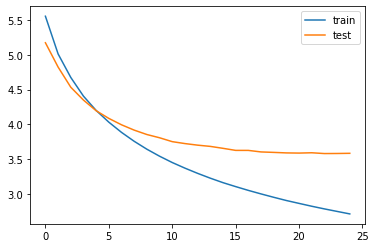

In [36]:
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show()

In [108]:
#4. 인퍼런스 모델 구현
src_index_to_word = src_tokenizer.index_word # 원문 단어 집합에서 정수 -> 단어를 얻음
tar_word_to_index = tar_tokenizer.word_index # 요약 단어 집합에서 단어 -> 정수를 얻음
tar_index_to_word = tar_tokenizer.index_word # 요약 단어 집합에서 정수 -> 단어를 얻음

#4-1. 인코더 설계
encoder_model = Model(inputs=encoder_inputs, outputs=[encoder_outputs, state_h, state_c])

# 이전 시점의 상태들을 저장하는 텐서
decoder_state_input_h = Input(shape=(hidden_size,))
decoder_state_input_c = Input(shape=(hidden_size,))

dec_emb2 = dec_emb_layer(decoder_inputs)

# 문장의 다음 단어를 예측하기 위해서 초기 상태(initial_state)를 이전 시점의 상태로 사용. 이는 뒤의 함수 decode_sequence()에 구현
# 훈련 과정에서와 달리 LSTM의 리턴하는 은닉 상태와 셀 상태인 state_h와 state_c를 버리지 않음.
decoder_outputs2, state_h2, state_c2 = decoder_lstm(dec_emb2, initial_state=[decoder_state_input_h, decoder_state_input_c])

#4-2. 어텐션 함수
decoder_hidden_state_input = Input(shape=(text_max_len, hidden_size))
attn_out_inf = attn_layer([decoder_outputs2, decoder_hidden_state_input])
decoder_inf_concat = Concatenate(axis=-1, name='concat')([decoder_outputs2, attn_out_inf])

# 디코더의 출력층
decoder_outputs2 = decoder_softmax_layer(decoder_inf_concat) 

#4-3. 최종 디코더 모델
decoder_model = Model(
    [decoder_inputs] + [decoder_hidden_state_input,decoder_state_input_h, decoder_state_input_c],
    [decoder_outputs2] + [state_h2, state_c2])

def decode_sequence(input_seq):
    # 입력으로부터 인코더의 상태를 얻음
    e_out, e_h, e_c = encoder_model.predict(input_seq)

     # <SOS>에 해당하는 토큰 생성
    target_seq = np.zeros((1,1))
    target_seq[0, 0] = tar_word_to_index['sostoken']

    stop_condition = False
    decoded_sentence = ''
    while not stop_condition: # stop_condition이 True가 될 때까지 루프 반복

        output_tokens, h, c = decoder_model.predict([target_seq] + [e_out, e_h, e_c])
        sampled_token_index = np.argmax(output_tokens[0, -1, :])
        sampled_token = tar_index_to_word[sampled_token_index]

        if (sampled_token!='eostoken'):
            decoded_sentence += ' '+sampled_token

        #  <eos>에 도달하거나 최대 길이를 넘으면 중단.
        if (sampled_token == 'eostoken'  or len(decoded_sentence.split()) >= (headlines_max_len-1)):
            stop_condition = True

        # 길이가 1인 타겟 시퀀스를 업데이트
        target_seq = np.zeros((1,1))
        target_seq[0, 0] = sampled_token_index

        # 상태를 업데이트 합니다.
        e_h, e_c = h, c

    return decoded_sentence

In [109]:
#5. 모델 테스트
#5-1. 원문의 정수 시퀀스를 텍스트 시퀀스로 변환하는 함수 구현
def seq2text(input_seq):
    temp=''
    for i in input_seq:
        if (i!=0):
            temp = temp + src_index_to_word[i]+' '
    return temp

#5-2. 요약문의 정수 시퀀스를 텍스트 시퀀스로 변환하는 함수 구현
def seq2summary(input_seq):
    temp=''
    for i in input_seq:
        if ((i!=0 and i!=tar_word_to_index['sostoken']) and i!=tar_word_to_index['eostoken']):
            temp = temp + tar_index_to_word[i] + ' '
    return temp

In [161]:
#5-3. 예측과 실제 요약을 비교
for i in range(0, 10):
    print("원문 :", seq2text(encoder_input_test[i]))
    print("실제 요약 :", seq2summary(decoder_input_test[i]))
    print("예측 요약 :", decode_sequence(encoder_input_test[i].reshape(1, text_max_len)))
    print("\n")

원문 : head amazon studios roy price officially resigned post amazon show producer accused sexually harassing amazon studios ceo albert oversee operations amazon searches price replacement company said tuesday amazon suspended price light allegations earlier week 
실제 요약 : amazon studios head roy price quits amid harassment scandal 
예측 요약 :  differently regional ex ex stardom kidney democracy faster faster faster


원문 : telangana government said provide broadband internet connection households state december next year internet connection every house healthcare education rural areas undergo revolutionary changes information technology minister kt rama rao said rao directed officials speed work achieve target 
실제 요약 : all telangana to get internet by december 
예측 요약 :  meant arrested mice steals tabu opportunity shouts captains japanese stokes


원문 : employee burger project restaurant australian city melbourne fired using word receipt given black customer shared story facebook condemning di

In [221]:
from summa.summarizer import summarize
import requests

text = requests.get('http://rare-technologies.com/the_matrix_synopsis.txt').text

In [225]:
print('Summary:')
print(summarize(text, ratio=0.005))
print('Summary:')
print(decode_sequence(encoder_input_test[i].reshape(1, text_max_len)))

Summary:
Morpheus, Trinity, Neo, Apoc, Switch, Mouse and Cypher are jacked into the Matrix.
Trinity brings the helicopter down to the floor that Morpheus is on and Neo opens fire on the three Agents.
Summary:
 remember due removed residents offender station ponting upset norms asked
